In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import pickle

# Progress bar
from tqdm import tqdm

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as ltb

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import MetaLearner, BaseModel, evaluator, MetaModel
from utils import load_dataset

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Macros

In [2]:
META_LABEL_METRIC = "kappa"
DATASET = "electricity"
INCLUDE_DRIFT_METRICS = True

BASE_MODEL = RandomForestClassifier
# BASE_MODEL_HYPERPARAMS = {"probability": True}  # SVC
BASE_MODEL_HYPERPARAMS = {"max_depth": 6}  # RandomForest and DecisionTree
# BASE_MODEL_HYPERPARAMS = {}  # Logistic Regression

FILE_NAME = f"basemodel: {BASE_MODEL.__name__} - metric: {META_LABEL_METRIC} - dataset: {DATASET}"
if INCLUDE_DRIFT_METRICS:
    FILE_NAME += " - with_drift_metrics"
FILE_NAME

'basemodel: RandomForestClassifier - metric: kappa - dataset: electricity - with_drift_metrics'

In [3]:
# Macros
CLASS_COL = "class"
BASE_MODEL_TYPE = "binary_classification"  # multiclass or binary_classification or regression

OFFLINE_PHASE_SIZE = 5000
BASE_TRAIN_SIZE = 2000
R_STATE = 123

ETA = 200  # Window size used to extract meta features (100 for electricity)
STEP = 30  # Step for next meta learning iteration (30 for electricity)
TARGET_DELAY = 500

## Read data

In [4]:
df = load_dataset(DATASET)
print(df.shape)
df = df.head(10000)
df.head()

(45312, 7)


,nswprice,nswdemand,vicprice,vicdemand,transfer,class,weekday
0,0.056443,0.439155,0.003467,0.422915,0.414912,UP,2
1,0.051699,0.415055,0.003467,0.422915,0.414912,UP,2
2,0.051489,0.385004,0.003467,0.422915,0.414912,UP,2
3,0.045485,0.314639,0.003467,0.422915,0.414912,UP,2
4,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,2


In [5]:
n = df.shape[0]
class_weight = df[CLASS_COL].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{'DOWN': 0.5667, 'UP': 0.4333}

In [6]:
# offline
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
base_train_df = offline_df.iloc[:BASE_TRAIN_SIZE]
meta_train_df = offline_df.iloc[BASE_TRAIN_SIZE:]

# online
online_df = df.iloc[OFFLINE_PHASE_SIZE:]
online_features = online_df.drop(CLASS_COL, axis=1).reset_index(drop=True)
online_targets = online_df[CLASS_COL].reset_index(drop=True)

## Offline stage

In [7]:
base_model_params = {"verbose": True, "basis_model": BASE_MODEL, "hyperparameters": BASE_MODEL_HYPERPARAMS}
learner_params = {
    "base_model_params": base_model_params,
    "base_model_class_column": CLASS_COL,
    "eta": ETA,
    "step": STEP,
    "verbose": True,
    "target_delay": TARGET_DELAY,
    "base_model_type": BASE_MODEL_TYPE,
    "include_drift_metrics_mfs": INCLUDE_DRIFT_METRICS,
    }

learner = MetaLearner(**learner_params).fit(base_train_df, meta_train_df)

[I 2022-11-19 19:38:10,599] A new study created in memory with name: Meta Model


Training model with instances 0 to 97
Starting hyperparam tuning


[I 2022-11-19 19:38:10,823] Trial 0 finished with value: 0.017543730937747953 and parameters: {'num_leaves': 19, 'max_depth': 6}. Best is trial 0 with value: 0.017543730937747953.
[I 2022-11-19 19:38:11,001] Trial 1 finished with value: 0.017543730937747953 and parameters: {'num_leaves': 24, 'max_depth': 3}. Best is trial 0 with value: 0.017543730937747953.
[I 2022-11-19 19:38:11,177] Trial 2 finished with value: 0.017543730937747953 and parameters: {'num_leaves': 22, 'max_depth': 5}. Best is trial 0 with value: 0.017543730937747953.
[I 2022-11-19 19:38:11,358] Trial 3 finished with value: 0.017543730937747953 and parameters: {'num_leaves': 21, 'max_depth': 7}. Best is trial 0 with value: 0.017543730937747953.
[I 2022-11-19 19:38:11,546] Trial 4 finished with value: 0.017543730937747953 and parameters: {'num_leaves': 19, 'max_depth': 3}. Best is trial 0 with value: 0.017543730937747953.
[I 2022-11-19 19:38:11,932] Trial 5 finished with value: 0.017543730937747953 and parameters: {'num_

Best hyperparams: {'num_leaves': 19, 'max_depth': 6}
Finished meta model training
Training model with instances 0 to 97
Starting hyperparam tuning


[I 2022-11-19 19:38:13,671] Trial 0 finished with value: 0.017543730937747953 and parameters: {'num_leaves': 19, 'max_depth': 4}. Best is trial 0 with value: 0.017543730937747953.
[I 2022-11-19 19:38:13,847] Trial 1 finished with value: 0.017543730937747953 and parameters: {'num_leaves': 15, 'max_depth': 4}. Best is trial 0 with value: 0.017543730937747953.
[I 2022-11-19 19:38:14,024] Trial 2 finished with value: 0.017543730937747953 and parameters: {'num_leaves': 22, 'max_depth': 6}. Best is trial 0 with value: 0.017543730937747953.
[I 2022-11-19 19:38:14,201] Trial 3 finished with value: 0.017543730937747953 and parameters: {'num_leaves': 24, 'max_depth': 4}. Best is trial 0 with value: 0.017543730937747953.
[I 2022-11-19 19:38:14,383] Trial 4 finished with value: 0.017543730937747953 and parameters: {'num_leaves': 20, 'max_depth': 4}. Best is trial 0 with value: 0.017543730937747953.
[I 2022-11-19 19:38:14,766] Trial 5 finished with value: 0.017543730937747953 and parameters: {'num_

Best hyperparams: {'num_leaves': 19, 'max_depth': 4}
Finished meta model training
Training model with instances 0 to 97
Starting hyperparam tuning


[I 2022-11-19 19:38:16,142] Trial 0 finished with value: 0.01754373093774795 and parameters: {'num_leaves': 23, 'max_depth': 3}. Best is trial 0 with value: 0.01754373093774795.
[I 2022-11-19 19:38:16,316] Trial 1 finished with value: 0.01754373093774795 and parameters: {'num_leaves': 16, 'max_depth': 5}. Best is trial 0 with value: 0.01754373093774795.
[I 2022-11-19 19:38:16,491] Trial 2 finished with value: 0.01754373093774795 and parameters: {'num_leaves': 20, 'max_depth': 6}. Best is trial 0 with value: 0.01754373093774795.
[I 2022-11-19 19:38:16,665] Trial 3 finished with value: 0.01754373093774795 and parameters: {'num_leaves': 25, 'max_depth': 5}. Best is trial 0 with value: 0.01754373093774795.
[I 2022-11-19 19:38:16,841] Trial 4 finished with value: 0.01754373093774795 and parameters: {'num_leaves': 16, 'max_depth': 8}. Best is trial 0 with value: 0.01754373093774795.
[I 2022-11-19 19:38:17,220] Trial 5 finished with value: 0.01754373093774795 and parameters: {'num_leaves': 17

Best hyperparams: {'num_leaves': 23, 'max_depth': 3}
Finished meta model training
Training model with instances 0 to 97
Starting hyperparam tuning


[I 2022-11-19 19:38:18,637] Trial 0 finished with value: 0.059093657004117214 and parameters: {'num_leaves': 20, 'max_depth': 7}. Best is trial 0 with value: 0.059093657004117214.
[I 2022-11-19 19:38:18,811] Trial 1 finished with value: 0.059093657004117214 and parameters: {'num_leaves': 22, 'max_depth': 7}. Best is trial 0 with value: 0.059093657004117214.
[I 2022-11-19 19:38:18,985] Trial 2 finished with value: 0.059093657004117214 and parameters: {'num_leaves': 21, 'max_depth': 4}. Best is trial 0 with value: 0.059093657004117214.
[I 2022-11-19 19:38:19,158] Trial 3 finished with value: 0.059093657004117214 and parameters: {'num_leaves': 15, 'max_depth': 6}. Best is trial 0 with value: 0.059093657004117214.
[I 2022-11-19 19:38:19,328] Trial 4 finished with value: 0.059093657004117214 and parameters: {'num_leaves': 22, 'max_depth': 3}. Best is trial 0 with value: 0.059093657004117214.
[I 2022-11-19 19:38:19,710] Trial 5 finished with value: 0.059093657004117214 and parameters: {'num_

Best hyperparams: {'num_leaves': 20, 'max_depth': 7}
Finished meta model training
Training model with instances 0 to 97


## Online Stage

In [8]:
# start - no target
with tqdm(total=TARGET_DELAY) as pbar:
    for i, row in online_features.iloc[:TARGET_DELAY].iterrows():
        learner.update(row)
        pbar.update(1)

100%|██████████| 500/500 [00:24<00:00, 20.09it/s]


In [9]:
# middle - both target and instances
df = online_features.iloc[TARGET_DELAY:-TARGET_DELAY]

with tqdm(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        learner.update(row)
        learner.update_target(online_targets.iloc[i - TARGET_DELAY])
        pbar.update(1)

 22%|██▏       | 899/4000 [00:52<02:07, 24.40it/s]

Training model with instances 30 to 127
Finished meta model training
Training model with instances 30 to 127
Finished meta model training
Training model with instances 30 to 127
Finished meta model training
Training model with instances 30 to 127
Finished meta model training


 45%|████▌     | 1800/4000 [01:50<01:44, 21.06it/s]

Training model with instances 60 to 157
Finished meta model training
Training model with instances 60 to 157
Finished meta model training
Training model with instances 60 to 157
Finished meta model training
Training model with instances 60 to 157
Finished meta model training


 68%|██████▊   | 2700/4000 [02:33<00:59, 21.93it/s]

Training model with instances 90 to 187
Finished meta model training
Training model with instances 90 to 187
Finished meta model training
Training model with instances 90 to 187
Finished meta model training
Training model with instances 90 to 187
Finished meta model training


 90%|█████████ | 3600/4000 [03:20<00:30, 13.03it/s]

Training model with instances 120 to 217
Finished meta model training
Training model with instances 120 to 217
Finished meta model training
Training model with instances 120 to 217
Finished meta model training
Training model with instances 120 to 217
Finished meta model training


100%|██████████| 4000/4000 [03:43<00:00, 17.87it/s]


In [10]:
# end - only targets
with tqdm(total=TARGET_DELAY) as pbar:
    for target in online_targets.tail(TARGET_DELAY):
        learner.update_target(target)
        pbar.update(1)

100%|██████████| 500/500 [00:00<00:00, 1179.43it/s]

Training model with instances 150 to 247
Finished meta model training
Training model with instances 150 to 247
Finished meta model training
Training model with instances 150 to 247
Finished meta model training
Training model with instances 150 to 247
Finished meta model training


## Results

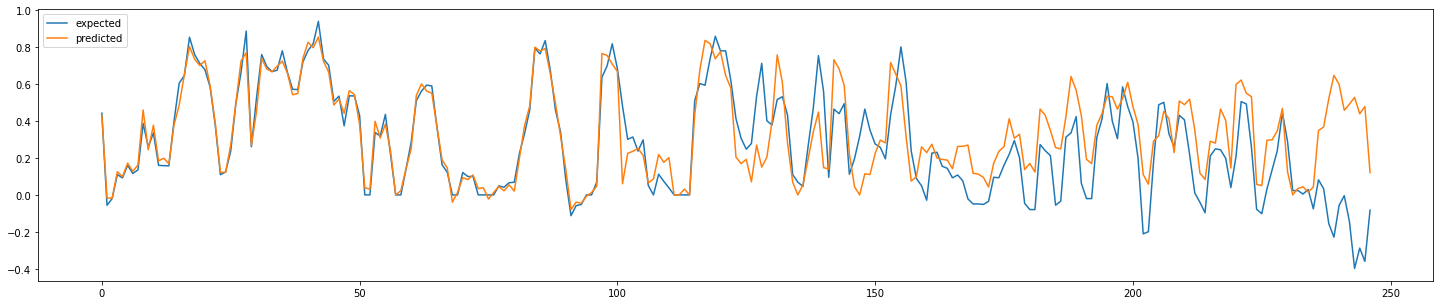

In [12]:
mb = learner.metabase.metabase

y_true = mb[META_LABEL_METRIC]
y_pred = mb[f'predicted_{META_LABEL_METRIC}']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

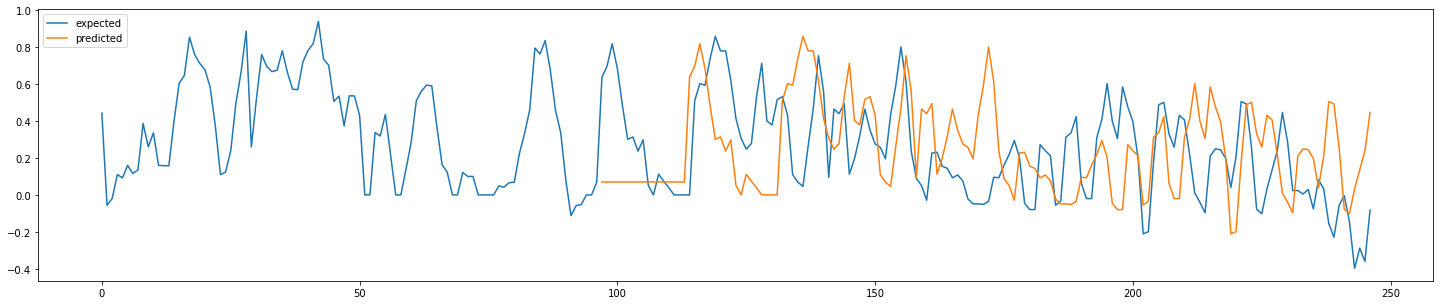

In [13]:
mb = learner.metabase.metabase

y_true = mb[META_LABEL_METRIC]
y_pred = mb[f'last_{META_LABEL_METRIC}']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

In [14]:
learner.elapsed_time

{'StatsMetrics': 28.208044052124023,
 'ClusteringMetrics': 86.28339982032776,
 'PsiCalculator': 6.883655786514282,
 'DomainClassifier': 23.435625553131104,
 'OmvPht': 0.3142738342285156,
 'SqsiCalculator': 19.605012893676758,
 'Udetector': 21.983728885650635}

In [16]:
{
    "dataset":" dataset",
    "base_model":" base_model",
    "include_drift":" include_drift",
    "total_elapsed_time":" time.time() - start",
    **learner.elapsed_time
}.keys()

dict_keys(['dataset', 'base_model', 'include_drift', 'total_elapsed_time', 'StatsMetrics', 'ClusteringMetrics', 'PsiCalculator', 'DomainClassifier', 'OmvPht', 'SqsiCalculator', 'Udetector'])

# Save metadata

In [ ]:
mb.to_csv(f"metabases/{FILE_NAME}.csv", index=False)

In [ ]:
with open(f"models/{FILE_NAME}.pickle", "wb") as handle:
    pickle.dump(learner.meta_model.model, handle, protocol=pickle.HIGHEST_PROTOCOL)